# Association

Modelling the explicit labelling of observations from different population components and comparison with standard mixture modelling and clustering techniques.

Model definition and simulation is done in `pyStan` with code in the `stan/` directory.

In [68]:
%matplotlib inline
from matplotlib import pyplot as plt
import pystan
import stan_utility
import vapeplot
vapeplot.set_palette('vaporwave')

## A simple mixture model

Consider observations drawn from a mixture of 2 gaussian distributions with different means and the same standard deviation. Each population has an associated weight, $w$, the set of which forms a 2-simplex. The model can be parameterised with a latent categorical variable or *label*, $\lambda$:

<div><center>
    $\lambda \sim Categorical(w)$   
    <center></div>

The observation $y_n$ is distributed according to which mixture componenet it is generated from.

<div><center>
    $y_k \sim Normal(\mu_k, \sigma^2)$   
    <center></div>
    
In order to treat this model in Stan, we marginalise over the discrete parameter:

<div><center>
    $p(y \ | \ w, \mu, \sigma) = \sum_{k = 1}^2 Normal( y \ | \ \mu_k, \sigma^2) $  
    <center></div>
    
  

In [71]:
# compile the stan simulation
simu_file = 'stan/simple_mixture_sim.stan'
simulation = stan_utility.compile_model(filename = simu_file)

Using cached StanModel


/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


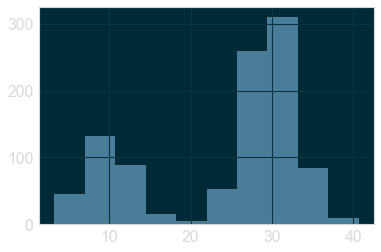

In [78]:
# Use stan to simulate draws from this mixutre model
simu_parameters = {'mu' : [10, 30],
                   'sigma' : 3, 
                   'w' : [0.3, 0.7], 
                   'N_obs' : 1000}

simu = simulation.sampling(data = simu_parameters, algorithm = "Fixed_param", 
                     iter = 1, chains = 1, seed = 19920715)

# plot the simulation
y_simu = sim.extract(['y'])['y'][0]
plt.hist(y_simu, alpha = 0.5);

# dump the simulated data to a file
simu_data = {'N_obs' : len(y_simu), 'y' : y_simu}
data_file = 'data/simple_mixture.data.R'
pystan.stan_rdump(simu_data, data_file)

In [74]:
# compile the stan model
model_file = 'stan/simple_mixture.stan'
model = stan_utility.compile_model(filename = model_file)

Using cached StanModel


In [79]:
# fit the stan model
data = pystan.read_rdump(data_file)

fit = model.sampling(data = data, iter = 1000, chains = 4, seed = 19920715)
print(fit)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_72b8af4e8332afb48865a8b41b83c449.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[0]    0.28  3.4e-4   0.01   0.26   0.27   0.28   0.29   0.31   1798    1.0
w[1]    0.72  3.4e-4   0.01   0.69   0.71   0.72   0.73   0.74   1798    1.0
mu[0]   9.98  4.9e-3   0.18   9.65   9.86   9.98   10.1  10.34   1301    1.0
mu[1]   29.9  2.4e-3   0.11  29.69  29.82   29.9  29.97   30.1   2000    1.0
sigma   2.99  1.7e-3   0.07   2.86   2.95   2.99   3.03   3.12   1621    1.0
lp__   -3104    0.06   1.38  -3107  -3105  -3104  -3103  -3102    522    1.0

Samples were drawn using NUTS at Sun May 20 14:29:17 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


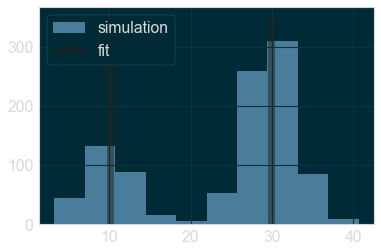

In [80]:
# plot the fit mu onto the simulated data
mu = fit.extract(['mu'])['mu'][0]
plt.hist(y_simu, label = 'simulation', alpha = 0.5);
plt.vlines([mu[0], mu[1]], 0, 350, 
           linewidth = 7, alpha = 0.5, label = 'fit')
plt.legend()

## Explicit modelling of the association

In more physical applications, we want to know the rigorous probability for the association of an observation $y_i$ with a population component $k$. In order to do this, we must consider the marginal probability. 